In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
data = pd.read_csv("./dataset/cleaned_news_summary.csv")
data.head()

,Unnamed: 0,author,date,headlines,read_more,text,ctext,cleaned_text,cleaned_headline
0,0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in offices order,http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.html?utm_source=inshorts&utm_medium...,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...,administration union territory daman diu revoked order made compulsory women tie rakhis male colleagues occasion rakshabandhan august administration forced withdraw decision within 24 hours issuin...,daman diu revokes mandatory rakshabandhan in offices order
1,1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorcing rich man',http://www.hindustantimes.com/bollywood/malaika-arora-khan-was-trolled-for-divorcing-a-rich-man-her-reply-is-dignity-itself/story-oIPZNI9deImCmabLMMwR2H.html?utm_source=inshorts&utm_medium=referra...,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...","From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster ...",malaika arora slammed instagram user trolled divorcing rich man fun alimony life wearing short clothes going gym salon enjoying vacations user commented malaika responded certainly got get damn fa...,malaika slams user who trolled her for divorcing rich man
2,2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS' form,http://www.hindustantimes.com/patna/bihar-igims-form-loses-virginity-after-row-opts-for-unmarried-instead/story-8XmHIg39otGBoZAYEBQxMK.html?utm_source=inshorts&utm_medium=referral&utm_campaign=ful...,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...","The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna amended its marital declaration form on Thursday, replacing the word ?virgin? with ?unmarried? after controversy.Until now, new rec...",indira gandhi institute medical sciences igims patna thursday made corrections marital declaration form changing virgin option unmarried earlier bihar health minister defined virgin unmarried woma...,virgin now corrected to unmarried in igims form
3,3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before being killed,http://indiatoday.intoday.in/story/abu-dujana-last-phone-call-lashkar-e-taiba-jammu-and-kashmir/1/1017550.html?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a...","Lashkar-e-Taiba's Kashmir commander Abu Dujana was killed in an encounter in a village in Pulwama district of Jammu and Kashmir earlier this week. Dujana, who had managed to give the security forc...",lashkaretaibas kashmir commander abu dujana killed security forces said kabhi hum aage kabhi aap aaj aapne pakad liya mubarak ho aapko today caught congratulations caught added wont surrender what...,aaj aapne pakad liya let man dujana before being killed
4,4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of sex trafficking

In [30]:
news = data.cleaned_text
headline = data.cleaned_headline
news_len = []
headline_len = []
for obj in range(len(news)):
    news_len.append(len(news[obj].split()))
    headline_len.append(len(headline[obj].split()))

Text(0.5, 1.0, 'Distribution of length of news text')

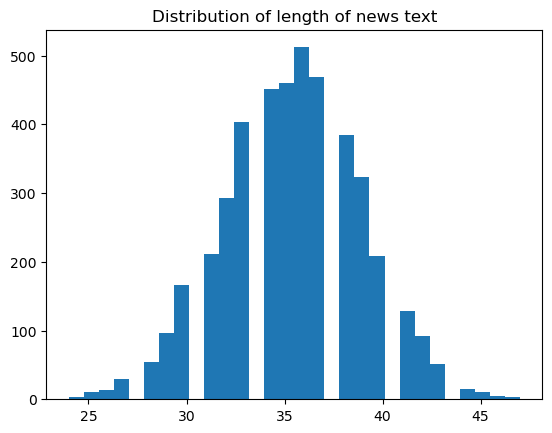

In [31]:
plt.hist(news_len, bins=30)
plt.title("Distribution of length of news text")

Text(0.5, 1.0, 'Distribution of length of headline text')

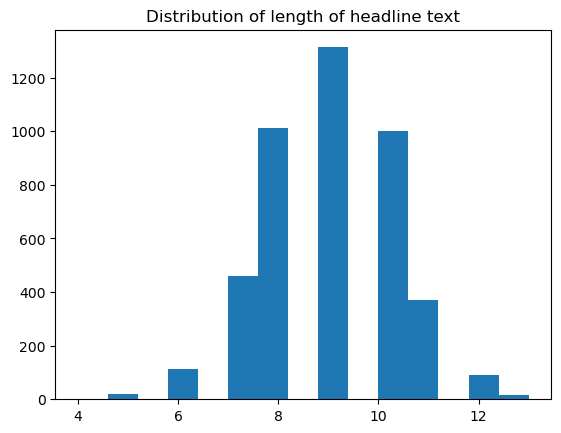

In [32]:
plt.hist(headline_len, bins=15)
plt.title("Distribution of length of headline text")

In [33]:
max_len_news = 50
max_len_headline = 13

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.cleaned_text, data.cleaned_headline, test_size=0.2, random_state=101, shuffle=True)

In [35]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention_my import AttentionLayer


import warnings

pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')

In [36]:
X_train

742     new airport project navi mumbai take away 250 hectares forest land 106 hectares mangrove cover mangrove saplings planted across 160 hectares play crucial role stabilising coastlines rehabilitation...
1776    according reports actor shahid kapoor admitted starstruck twinkle khanna teenager reportedly revealed would wait hours catch glimpse twinkle hotel swimming pool shoot 1997 film itihaas shahids mot...
24      two sunbathers 56yearold man eightyearold girl killed wednesday light plane struck making emergency landing beach portugal others run sea save two occupants plane appeared difficulty partly broken...
3383    election commission said thursday hold open hackathon last week may allowing people try hack evms announcement comes amid various political parties leaders alleging tampering evms elections ec ear...
2674    panchayat village rajasthan issued order prohibiting girls wearing jeans keeping mobile phones panchayat also decided dispute regarding order would referred pan

In [37]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))
X_train = X_tokenizer.texts_to_sequences(X_train)
X_test = X_tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen = max_len_news, padding='post')
X_test = pad_sequences(X_test, maxlen = max_len_news, padding='post')

news_vocab_size = len(X_tokenizer.word_index) + 1

In [38]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_train = y_tokenizer.texts_to_sequences(y_train)
y_test = y_tokenizer.texts_to_sequences(y_test)

y_train = pad_sequences(y_train, maxlen=max_len_headline, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len_headline, padding='post')

In [39]:
y_voc_size = len(y_tokenizer.word_index) + 1

In [40]:
from keras import backend as K
K.clear_session()

latent_dim=500

enc_inputs = Input(shape=(max_len_news,))
embedding1 = Embedding(news_vocab_size,latent_dim)(enc_inputs)

lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
enc_output1, h1, c1 = lstm1(embedding1)

lstm2 = LSTM(latent_dim, return_sequences=True,return_state=True)
enc_output2, h2, c2 = lstm2(enc_output1)

lstm3 = LSTM(latent_dim, return_sequences=True,return_state=True)
enc_outputs, h3, c3 = lstm3(enc_output2)


decoder_inputs = Input(shape=(None, ))
dec_embedding = Embedding(y_voc_size, latent_dim)(decoder_inputs)

dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, fwd_state, back_state = dec_lstm(dec_embedding, initial_state = [h3, c3])



attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_state = attn_layer([enc_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([enc_inputs, decoder_inputs], decoder_outputs)
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 500)      9732000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                              

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [42]:
ea = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [43]:

history=model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[ea],batch_size=512, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/50
7/7 [==============================] - 87s 10s/step - loss: 8.3409 - val_loss: 6.2906
Epoch 2/50
7/7 [==============================] - 147s 23s/step - loss: 5.7296 - val_loss: 4.8761
Epoch 2: early stopping


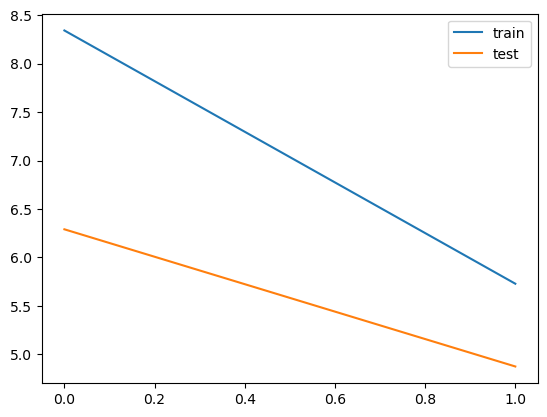

In [45]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()
